In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings("ignore")

In [36]:
data_root = r"./Data/REG_AMES/"
train = pd.read_csv(os.path.join(data_root, "train.csv"))
test = pd.read_csv(os.path.join(data_root, "test.csv"))

print(f"Train: {train.shape}")
print(f"Test: {test.shape}")

Train: (1460, 81)
Test: (1459, 80)


# 1. Preprocessing
- REF: (Kaggle) Stacked Regressions: Top 4% on LeaderBoard

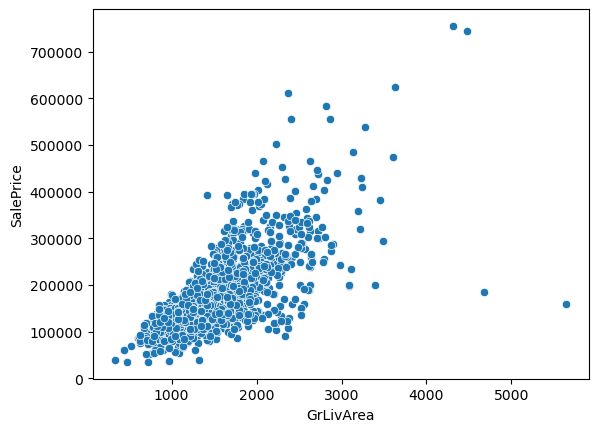

In [37]:
sns.scatterplot(x=train["GrLivArea"], y=train["SalePrice"])
plt.ylabel("SalePrice")
plt.xlabel("GrLivArea")
plt.show()

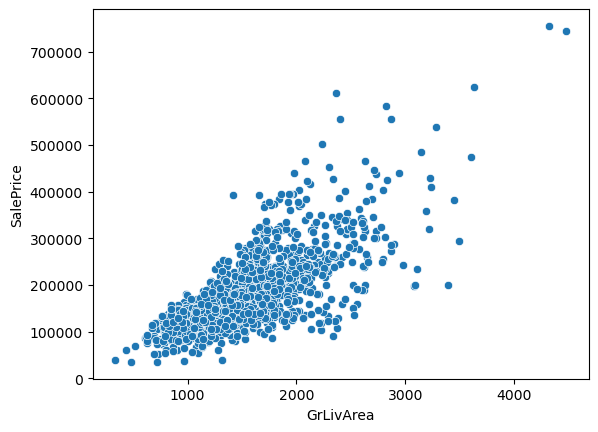

In [38]:
# 이상치 제거
train = train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index)
#
sns.scatterplot(x=train["GrLivArea"], y=train["SalePrice"])
plt.ylabel("SalePrice")
plt.xlabel("GrLivArea")
plt.show()

# 2. SalePrice 분포 확인

<Axes: xlabel='SalePrice', ylabel='Density'>

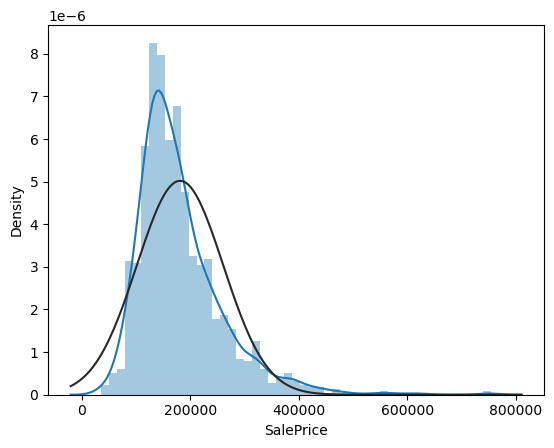

In [44]:
sns.distplot(train["SalePrice"], fit=norm)


mu=180932.92 and sigma=79467.79


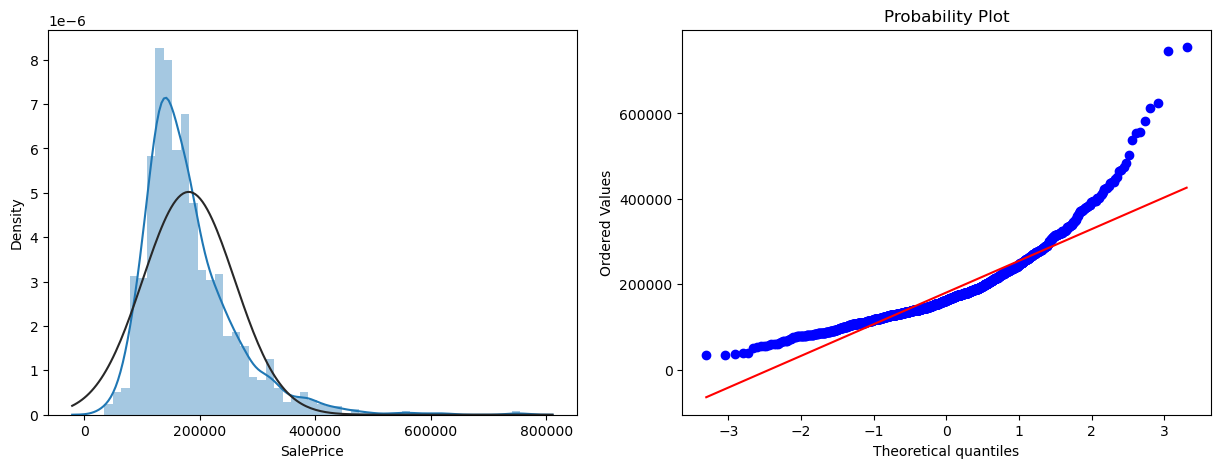

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.distplot(train["SalePrice"], fit=norm, ax=ax[0])
(mu, sigma) = norm.fit(train["SalePrice"])
print(f"\nmu={mu:.2f} and sigma={sigma:.2f}")
# ax[0].legend([f"Normal dist. ($\mu=${mu:.2f} and $\sigma=${sigma:.2f})"], loc="best")
plt.ylabel("Freq.")
plt.xlabel("SalePrice Distribution")
# QQ-plot
res = stats.probplot(train["SalePrice"], plot=ax[1])
plt.show()

# 3. Ftrs Engineering

In [6]:
ntrain, ntest = train.shape[0], test.shape[0]
y_train = train["SalePrice"].values
#
all_data = pd.concat([train, test]).reset_index(drop=True)
all_data = all_data.drop(["SalePrice"], axis=1)
#
print(f"Train+Test: {all_data.shape}")

Train+Test: (2917, 80)


### 3-1. 결측치 확인

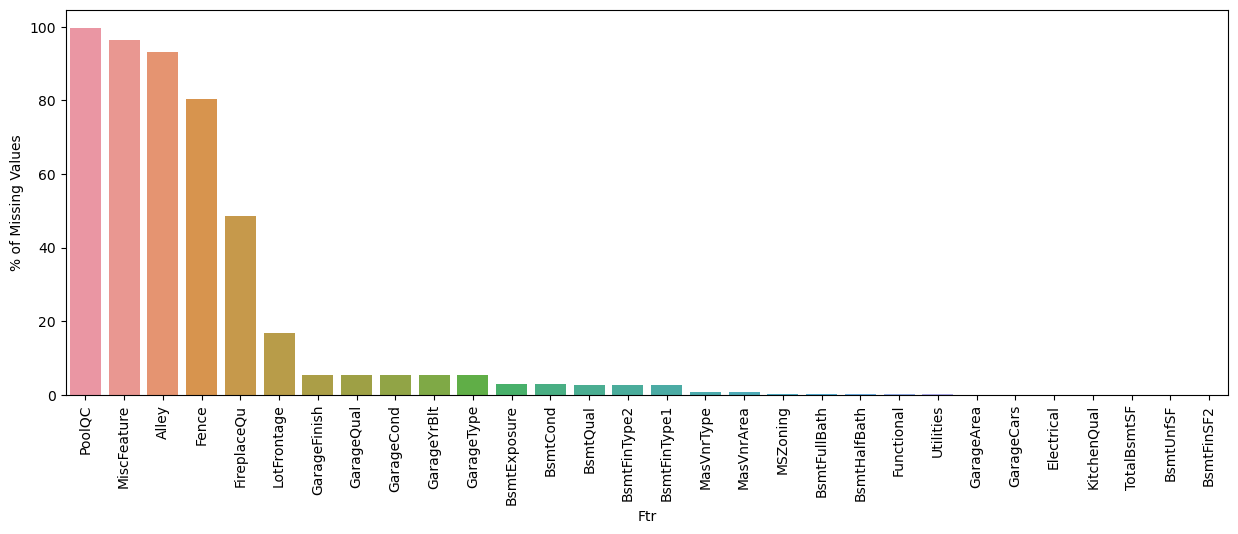

In [7]:
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missig Value":all_data_na})
#
plt.figure(figsize=(15, 5))
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel("Ftr")
plt.ylabel("% of Missing Values")
plt.xticks(rotation=90)
plt.show()

### 3-2. 상관계수

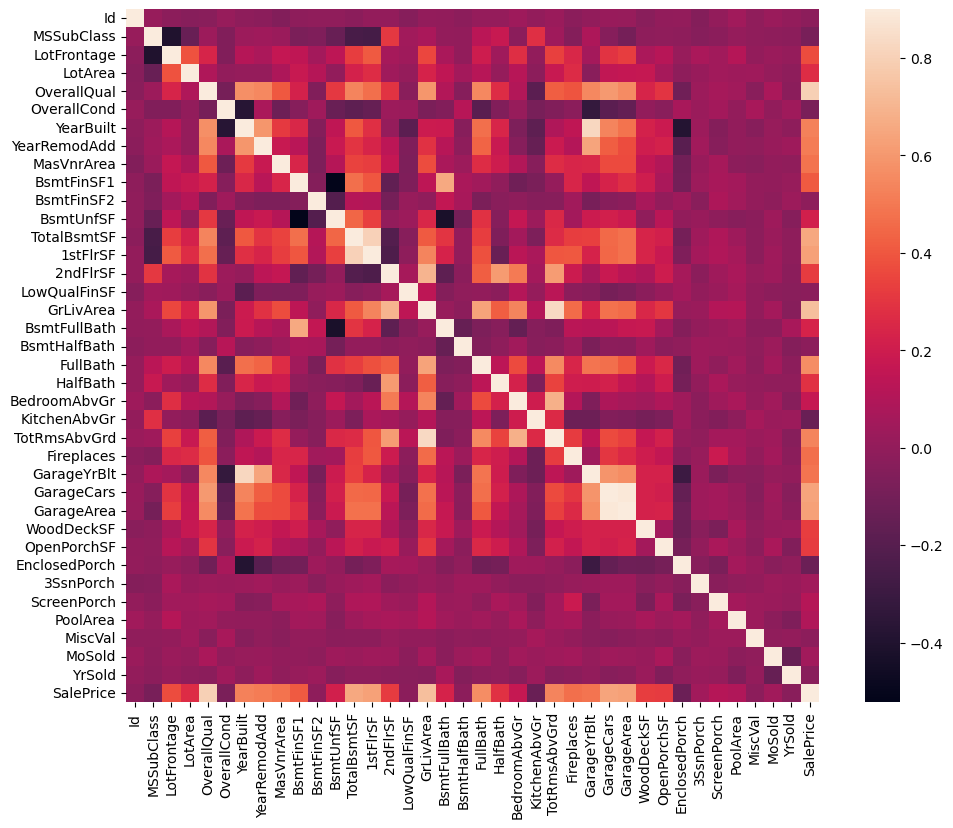

In [8]:
plt.figure(figsize=(12, 9))
sns.heatmap(train.corr(), vmax=0.9, square=True)
plt.show()

### 3.3 결측치 처리

In [9]:
# 결측치 처리 -> 데이터 설명 기반
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'): all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'): all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'): all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'): all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
print(f"결측치 처리 후: {missing_data.shape}")

결측치 처리 후: (0, 1)


### 3.4 인코딩 (라벨인코딩)

In [11]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
#
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 79)


### 3.5 파생변수 생성

In [12]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
#
numeric_feats = all_data.dtypes[all_data.dtypes!="object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
#
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)


Skew in numerical features: 

There are 60 skewed numerical features to Box Cox transform


# 4. Split

In [13]:
all_data = pd.get_dummies(all_data)
print(f"인코딩 후: {all_data.shape}")

인코딩 후: (2917, 221)


In [14]:
train = all_data[:ntrain]
test = all_data[ntrain:]

print(f"Encoded Train: {train.shape}")
print(f"Encoded Test: {test.shape}")

Encoded Train: (1458, 221)
Encoded Test: (1459, 221)


In [15]:
train = pd.concat([train.iloc[:, 1:], pd.DataFrame({"Y":y_train})], axis=1)

In [16]:
train.to_csv(r"./Data/Prep_AMES/train.csv", index=False)
test.iloc[:, 1:].to_csv(r"./Data/Prep_AMES/test.csv", index=False)

# 5. 검정

In [17]:
corr_table = train.corr()
corr_table = pd.DataFrame(corr_table["Y"])
corr_table["sig"] = corr_table["Y"].apply(lambda x: abs(x)>=0.5)
sig_ftrs = corr_table[corr_table["sig"]].index.tolist()

In [18]:
train[sig_ftrs].to_csv("./Data/Prep_AMES/sig_train.csv")

In [20]:
corr = train[sig_ftrs].corr()

In [32]:
len(sig_ftrs)

13

Text(0.5, 1.0, 'AMES Corr')

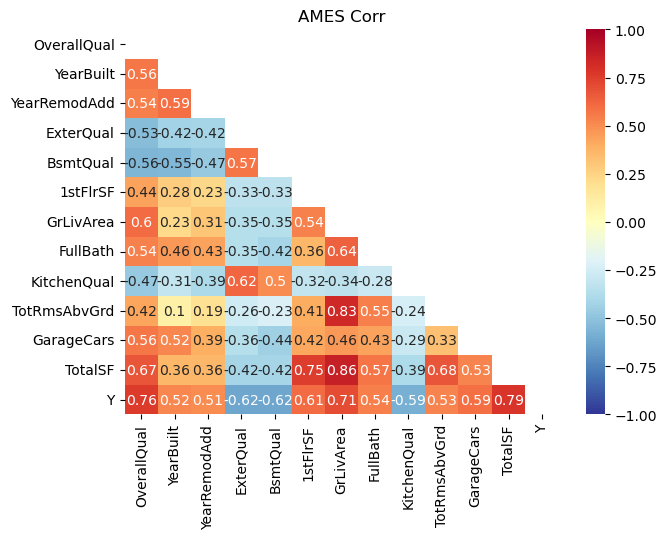

In [30]:
plt.figure(figsize=(7, 5))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, cmap="RdYlBu_r", vmin=-1, vmax=1, mask=mask)
plt.title("AMES Corr")